# Technology & Innovation Analyst — DIVE Analysis (2022 NYC Taxi)

**Dataset:** `bigquery-public-data.new_york_taxi_trips` (**use only 2022**)  
**Role:** Technology & Innovation Analyst  
**What this notebook delivers:** a complete DIVE analysis with executable BigQuery SQL, charts (matplotlib), and embedded *Gemini prompt* cells.

**DIVE focus for this role**
- **Discover:** Technology adoption, digital capabilities, innovation metrics  
- **Investigate:** How does technology impact performance? Where are gaps?  
- **Validate:** Test technology ROI and adoption hypotheses  
- **Extend:** Technology investment & innovation strategy

> If not already in Google Colab, open this in Colab for the smoothest BigQuery experience.


## Setup (Colab)
Run once: install dependencies and authenticate BigQuery.


In [ ]:
# ✅ Install known-good versions for Colab (Aug 2025)
!pip install -q \
  pandas==2.2.2 \
  google-cloud-bigquery==3.25.0 \
  pandas-gbq==0.22.0 \
  pyarrow==16.1.0 \
  matplotlib==3.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 128.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.14.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.14.0 requires pandas-gbq>=0.26.1, but you have pandas-gbq 0.22.0 which is incompatible.


In [ ]:
# --- COLAB AUTH + BIGQUERY CLIENT FOR PROJECT my-project-taxi-469003 ---

# 1) OAuth in Colab (you should see a Google popup)
from google.colab import auth
auth.authenticate_user()
print("Colab OAuth: OK")

# 2) Get credentials & default project
import google.auth
from google.auth.transport.requests import Request
creds, default_project = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(Request())

# 3) Set your billing project explicitly
PROJECT_ID = "my-project-taxi-469003"  # <-- your project ID

# 4) Create BigQuery client with creds & project
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, credentials=creds)

import pandas as pd
import matplotlib.pyplot as plt

print("BigQuery client ready for:", client.project)


Colab OAuth: OK
BigQuery client ready for: my-project-taxi-469003


In [ ]:
# === Quick reset helper (run once per session) ===
import pandas as pd
from google.cloud import bigquery

try:
    client  # reuse if it already exists
except NameError:
    client = bigquery.Client(project="my-project-taxi-469003")  # <-- your project ID

def run_bq(sql: str) -> pd.DataFrame:
    job = client.query(sql)
    return job.result().to_dataframe(create_bqstorage_client=True)

print("BigQuery ready — project:", client.project)


BigQuery ready — project: my-project-taxi-469003


In [ ]:
run_bq("""
SELECT table_name
FROM `bigquery-public-data.new_york_taxi_trips`.INFORMATION_SCHEMA.TABLES
WHERE REGEXP_CONTAINS(table_name, r'2022')
ORDER BY table_name
""").head()

,table_name
0,tlc_green_trips_2022
1,tlc_yellow_trips_2022


## Confirm the 2022 tables exist
We will use only **2022** partitions/snapshots.


In [ ]:

sql_tables_2022 = """
SELECT table_name
FROM `bigquery-public-data.new_york_taxi_trips`.INFORMATION_SCHEMA.TABLES
WHERE REGEXP_CONTAINS(table_name, r'2022')
ORDER BY table_name
"""

df_tables = run_bq(sql_tables_2022)
df_tables


,table_name
0,tlc_green_trips_2022
1,tlc_yellow_trips_2022


In [ ]:
# Re-auth + rebuild BigQuery client (safe to run anytime)
from google.colab import auth
auth.authenticate_user()

import google.auth
creds, _ = google.auth.default(scopes=['https://www.googleapis.com/auth/cloud-platform'])

from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "my-project-taxi-469003"   # <-- your project
client = bigquery.Client(project=PROJECT_ID, credentials=creds)

def run_bq(sql: str) -> pd.DataFrame:
    job = client.query(sql)
    return job.result().to_dataframe(create_bqstorage_client=True)

print("BigQuery ready →", client.project)


BigQuery ready → my-project-taxi-469003


In [ ]:
# --- Auto-fix for schema + zone join (run once) ---
# Finds the right join key (zone_id vs location_id) and borough column
cols = run_bq("""
SELECT column_name
FROM `bigquery-public-data.new_york_taxi_trips`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'taxi_zone_geom'
ORDER BY column_name
""")
names = [c.lower() for c in cols['column_name'].tolist()]
print("taxi_zone_geom columns:", names)

# join key
join_col = next((c for c in ["location_id","locationid","zone_id","zoneid","loc_id","locid"] if c in names), None)
if not join_col:
    raise ValueError(f"No join column found in taxi_zone_geom; saw: {names}")

# borough column
if   "borough" in names: boro_col = "borough"
elif "boro"    in names: boro_col = "boro"
else:
    raise ValueError(f"No borough column found in taxi_zone_geom; saw: {names}")

print("Using join column:", join_col)
print("Using borough column:", boro_col)


taxi_zone_geom columns: ['borough', 'zone_geom', 'zone_id', 'zone_name']
Using join column: zone_id
Using borough column: borough


## Canonical 2022 `trips_2022` view (logical CTE)
Unifies **Yellow** & **Green** 2022 trips into one schema and enriches with borough + basic *tech* signals:
- `is_card` (payment_type = 1) as digital payment adoption
- `store_and_fwd_flag` proxy for connectivity
- `tip_rate` as UX/checkout behavior
- `hour`, `month` for temporal patterns


In [12]:
# ---- Canonical 2022 trips (type-safe, consistent types) ----
canonical_trips_sql = r"""
WITH yellow AS (
  SELECT
    'yellow' AS service_type,
    pickup_datetime,
    dropoff_datetime,
    CAST(pickup_location_id AS INT64)     AS pu_zone_id,
    SAFE_CAST(trip_distance AS FLOAT64)   AS trip_distance,
    SAFE_CAST(fare_amount   AS FLOAT64)   AS fare_amount,
    SAFE_CAST(tip_amount    AS FLOAT64)   AS tip_amount,
    SAFE_CAST(total_amount  AS FLOAT64)   AS total_amount,
    SAFE_CAST(payment_type  AS INT64)     AS payment_type_int,
    CAST(store_and_fwd_flag AS STRING)    AS store_and_fwd_flag
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2022`
),
green AS (
  SELECT
    'green'  AS service_type,
    pickup_datetime,
    dropoff_datetime,
    CAST(pickup_location_id AS INT64)     AS pu_zone_id,
    SAFE_CAST(trip_distance AS FLOAT64)   AS trip_distance,
    SAFE_CAST(fare_amount   AS FLOAT64)   AS fare_amount,
    SAFE_CAST(tip_amount    AS FLOAT64)   AS tip_amount,
    SAFE_CAST(total_amount  AS FLOAT64)   AS total_amount,
    SAFE_CAST(payment_type  AS INT64)     AS payment_type_int,
    CAST(store_and_fwd_flag AS STRING)    AS store_and_fwd_flag
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2022`
),
base AS (
  SELECT * FROM yellow
  UNION ALL
  SELECT * FROM green
),
enriched AS (
  SELECT
    b.*,
    z.borough AS pu_borough
  FROM base b
  LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` z
    ON b.pu_zone_id = SAFE_CAST(z.zone_id AS INT64)      -- INT64 = INT64
)
SELECT
  service_type,
  pickup_datetime,
  dropoff_datetime,
  pu_zone_id,
  pu_borough,
  trip_distance,
  fare_amount,
  tip_amount,
  total_amount,
  payment_type_int,
  store_and_fwd_flag,
  EXTRACT(HOUR  FROM pickup_datetime)  AS hour,
  EXTRACT(MONTH FROM pickup_datetime)  AS month,
  SAFE_DIVIDE(tip_amount, NULLIF(fare_amount,0))         AS tip_rate,
  CASE WHEN payment_type_int = 1 THEN 1 ELSE 0 END       AS is_card,
  CASE WHEN UPPER(store_and_fwd_flag) IN ('Y','1','T','TRUE')
       THEN 1 ELSE 0 END                                 AS is_store_and_forward
FROM enriched
"""
print("✅ canonical_trips_sql reset with INT64 join + consistent types.")



✅ canonical_trips_sql reset with INT64 join + consistent types.


# D — Discover
Baseline **technology adoption** & **digital capability** metrics by *borough × month (2022)*.

**KPIs**
- Digital payment share = AVG(`is_card`)
- Connectivity proxy = AVG(`is_store_and_forward`)
- Avg `tip_rate`
- Trips (volume)


**Gemini Prompt — Discover**  
*I'm analyzing 2022 NYC taxi data to measure technology adoption. Here is my borough-by-month summary (digital-pay share, store-and-forward share, tip rate, trip volume). What non-obvious patterns/outliers should I explore? Suggest 3 plausible explanations grounded in rider/driver behavior or urban context.*


In [ ]:
discover_sql = f"""
WITH trips_2022 AS (
  {canonical_trips_sql}
)
SELECT
  pu_borough,
  month,
  COUNT(*)                   AS trips,
  AVG(is_card)               AS digital_pay_share,
  AVG(is_store_and_forward)  AS saf_share,
  AVG(tip_rate)              AS avg_tip_rate,
  AVG(trip_distance)         AS avg_dist
FROM trips_2022
WHERE pu_borough IS NOT NULL
GROUP BY pu_borough, month
ORDER BY pu_borough, month
"""
df_discover = run_bq(discover_sql)
df_discover.head()


,pu_borough,month,trips,digital_pay_share,saf_share,avg_tip_rate,avg_dist
0,Bronx,1,6858,0.367017,0.014436,0.116090,165.559172
1,Bronx,2,6781,0.420145,0.010323,0.047031,180.928005
2,Bronx,3,7117,0.477870,0.013348,0.069221,55.296662
3,Bronx,4,6749,0.456068,0.010224,1.473217,112.566762
4,Bronx,5,6634,0.408954,0.012059,0.076550,176.674295


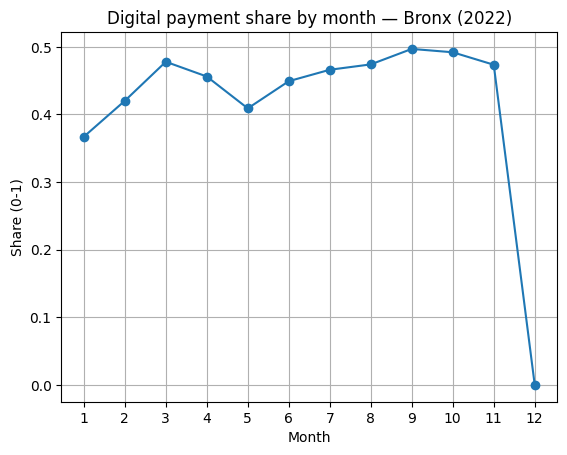

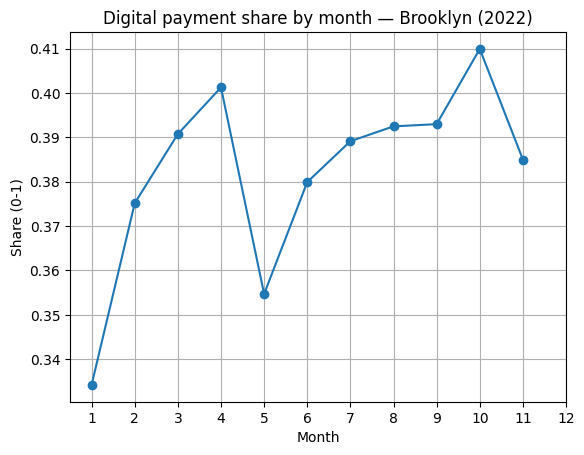

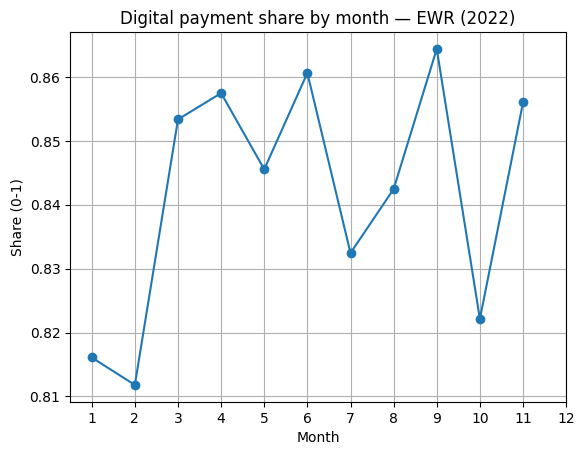

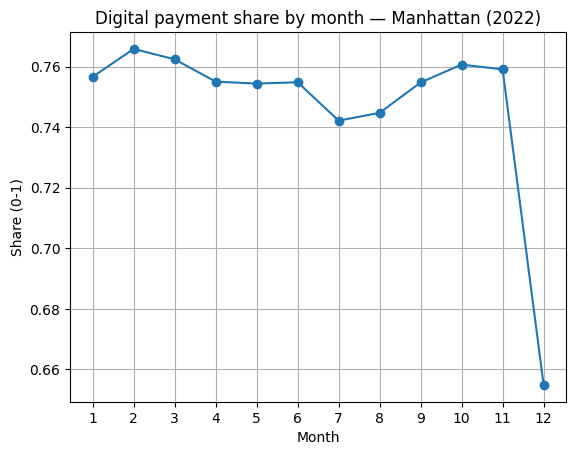

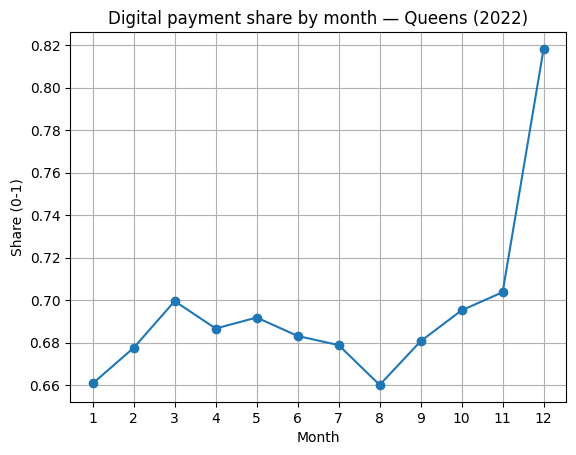

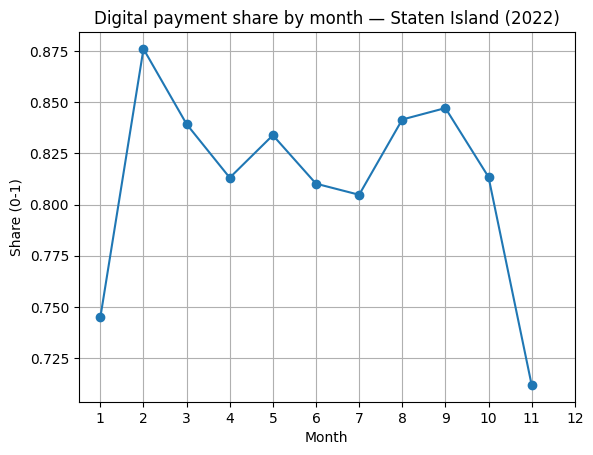

In [ ]:

# Plot monthly digital payment share by borough (matplotlib)
for b in sorted(df_discover['pu_borough'].unique()):
    sub = df_discover[df_discover['pu_borough']==b].sort_values('month')
    plt.figure()
    plt.plot(sub['month'], sub['digital_pay_share'], marker='o')
    plt.title(f"Digital payment share by month — {b} (2022)")
    plt.xlabel("Month"); plt.ylabel("Share (0-1)")
    plt.xticks(range(1,13))
    plt.grid(True)
    plt.show()


In [ ]:

# Rank boroughs by average digital adoption
rank = (df_discover.groupby('pu_borough')['digital_pay_share']
        .mean().sort_values(ascending=False).reset_index())
rank


,pu_borough,digital_pay_share
0,EWR,0.842028
1,Staten Island,0.812419
2,Manhattan,0.747141
3,Queens,0.694696
4,Bronx,0.415125
5,Brooklyn,0.382318


# I — Investigate
Do **technology choices** correlate with **performance/behavior**? We test three questions:

1. Does higher **digital-pay share** correlate with higher **tip rates**?  
2. Are areas with more **store-and-forward** (offline caching) showing **lower** digital-pay share?  
3. Are longer trips more likely to be paid with card?


**Gemini Prompt — Investigate**  
*Given these borough×month aggregates, explain whether correlations imply causation. Propose at least two confounders that we should control for in a follow-up analysis (e.g., trip length, airport trips, time-of-day).*


In [10]:
# --- BigQuery session bootstrap (run once per session) ---
import pandas as pd
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# >>>>>>> SET YOUR BILLING PROJECT HERE <<<<<<<
PROJECT_ID = "my-project-taxi-469003"   # <-- change if yours is different

# Create client bound to your billing project
client = bigquery.Client(project=PROJECT_ID)
print("BigQuery ready — project:", client.project)

def run_bq(sql: str) -> pd.DataFrame:
    job = client.query(sql)
    try:
        return job.result().to_dataframe(create_bqstorage_client=True)
    except Exception:
        return job.result().to_dataframe()


BigQuery ready — project: my-project-taxi-469003


In [11]:
run_bq("SELECT 'ok' AS status").head()


,status
0,ok


In [13]:
investigate_sql = f"""
WITH trips_2022 AS (
  {canonical_trips_sql}
),
agg AS (
  SELECT
    pu_borough,
    month,
    COUNT(*)                  AS trips,
    AVG(is_card)              AS digital_pay_share,
    AVG(is_store_and_forward) AS saf_share,
    AVG(tip_rate)             AS avg_tip_rate,
    AVG(trip_distance)        AS avg_dist
  FROM trips_2022
  WHERE pu_borough IS NOT NULL
  GROUP BY pu_borough, month
)
SELECT * FROM agg
ORDER BY pu_borough, month
"""
df_investigate = run_bq(investigate_sql)
df_investigate.head()


,pu_borough,month,trips,digital_pay_share,saf_share,avg_tip_rate,avg_dist
0,Bronx,1,6858,0.367017,0.014436,0.116090,165.559172
1,Bronx,2,6781,0.420145,0.010323,0.047031,180.928005
2,Bronx,3,7117,0.477870,0.013348,0.069221,55.296662
3,Bronx,4,6749,0.456068,0.010224,1.473217,112.566762
4,Bronx,5,6634,0.408954,0.012059,0.076550,176.674295


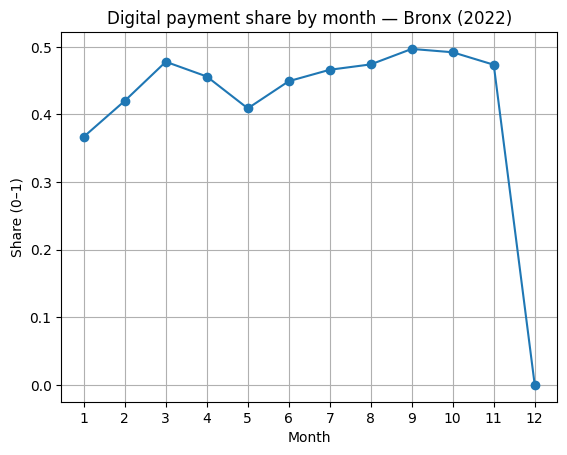

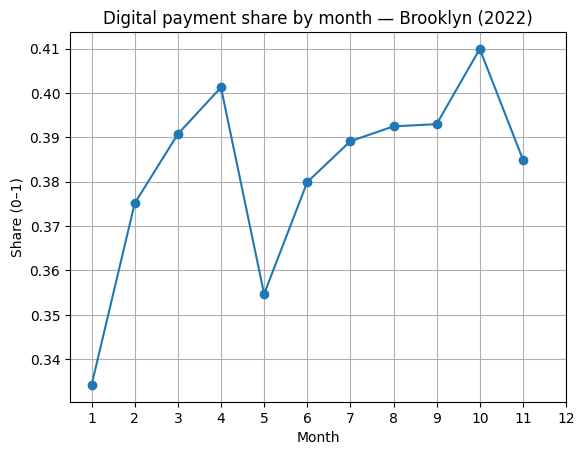

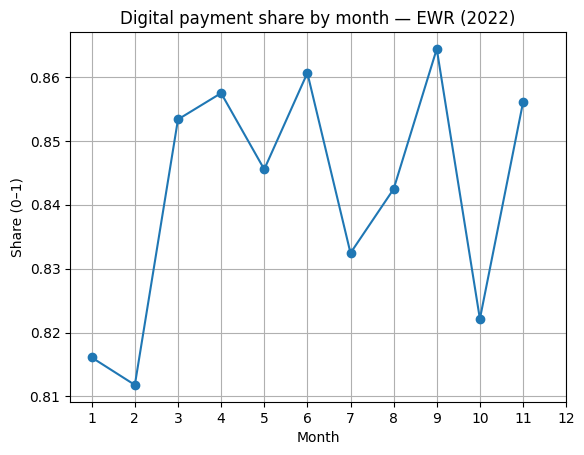

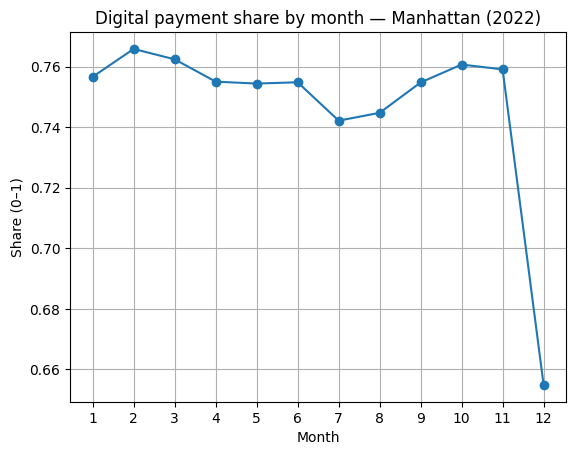

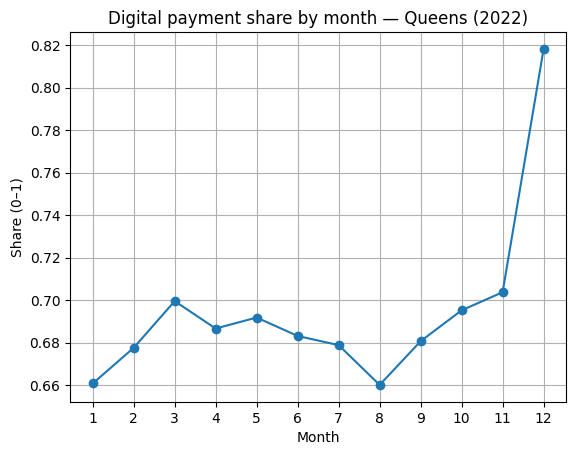

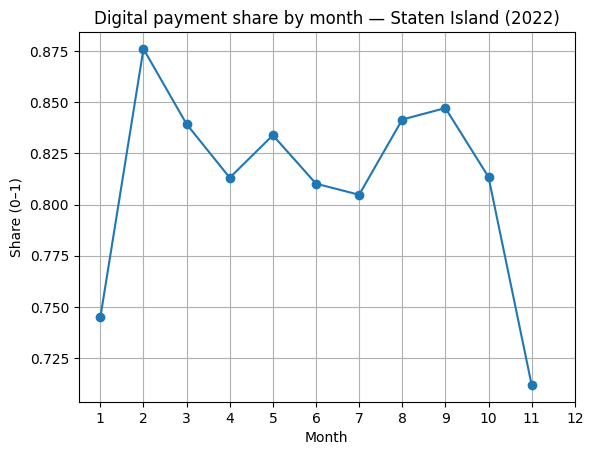

In [ ]:
import matplotlib.pyplot as plt

for b in sorted(df_discover['pu_borough'].unique()):
    sub = df_discover[df_discover['pu_borough'] == b].sort_values('month')
    plt.figure()
    plt.plot(sub['month'], sub['digital_pay_share'], marker='o')
    plt.title(f"Digital payment share by month — {b} (2022)")
    plt.xlabel("Month"); plt.ylabel("Share (0–1)")
    plt.xticks(range(1,13))
    plt.grid(True)
    plt.show()


In [ ]:
rank = (df_discover.groupby('pu_borough')['digital_pay_share']
        .mean().sort_values(ascending=False).reset_index())
rank


,pu_borough,digital_pay_share
0,EWR,0.842028
1,Staten Island,0.812419
2,Manhattan,0.747141
3,Queens,0.694696
4,Bronx,0.415125
5,Brooklyn,0.382318


# V — Validate
Test two ROI/adoption hypotheses using daily aggregates to avoid row-level export.

**H1 (Tips):** *Card payments yield higher tip rates than cash.*  
**H2 (Connectivity):** *Days/boroughs with higher store-and-forward share have **lower** card share.*

We use daily differences and quantiles to create empirical confidence bounds.


**Gemini Prompt — Validate**  
*Review the hypothesis results and bands. Are these effects economically meaningful? Recommend guardrails (e.g., minimum detectable effect, rolling-window checks) for production monitoring.*


In [14]:
import numpy as np, pandas as pd

def ols(X, y, names):
    X = np.column_stack([np.ones(len(X)), X])
    names = ['const'] + names
    XtX = X.T @ X
    beta = np.linalg.inv(XtX) @ X.T @ y
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    sigma2 = (resid @ resid) / (n - k)
    se = np.sqrt(np.diag(np.linalg.inv(XtX)) * sigma2)
    t = beta / se
    return pd.DataFrame({'term': names, 'coef': beta, 'stderr': se, 't': t})

# Uses df_investigate that you already built
X = df_investigate[['digital_pay_share','saf_share','avg_dist']].values
y = df_investigate['avg_tip_rate'].values
ols_table = ols(X, y, names=['digital','saf','avg_dist'])
ols_table


,term,coef,stderr,t
0,const,-0.289853,2.783076,-0.104148
1,digital,2.957353,3.440164,0.859655
2,saf,-90.125896,83.929185,-1.073833
3,avg_dist,0.001866,0.012341,0.151230


In [15]:
df_investigate_cap = df_investigate.copy()
df_investigate_cap['avg_tip_rate_cap'] = df_investigate_cap['avg_tip_rate'].clip(0, 0.5)

X = df_investigate_cap[['digital_pay_share','saf_share','avg_dist']].values
y = df_investigate_cap['avg_tip_rate_cap'].values
ols_table = ols(X, y, names=['digital','saf','avg_dist'])   # re-fit with capped tip rate
beta_dig = ols_table.loc[ols_table['term']=='digital','coef'].iloc[0]


In [ ]:
print("beta_dig (robust):", beta_dig)
ols_table.loc[ols_table['term']=='digital']


beta_dig (robust): 0.2698109028453948


,term,coef,stderr,t
1,digital,0.269811,0.123718,2.180858


In [16]:
# ---- Target segments: low digital adoption & high offline caching (SAF) ----
import pandas as pd

# thresholds (quartiles work well; adjust if you want stricter cutoffs)
q_low_digital = df_investigate['digital_pay_share'].quantile(0.25)
q_high_saf    = df_investigate['saf_share'].quantile(0.75)

targets = (
    df_investigate
      .loc[
          (df_investigate['digital_pay_share'] <= q_low_digital) &
          (df_investigate['saf_share'] >= q_high_saf)
      , ['pu_borough','month','trips','digital_pay_share','saf_share','avg_tip_rate','avg_dist']
      ]
      .sort_values(['pu_borough','month'])
      .reset_index(drop=True)
)

print("Cutoffs → low digital ≤", round(q_low_digital,3), " | high SAF ≥", round(q_high_saf,3))
targets.head(12)


Cutoffs → low digital ≤ 0.466  | high SAF ≥ 0.012


,pu_borough,month,trips,digital_pay_share,saf_share,avg_tip_rate,avg_dist
0,Bronx,1,6858,0.367017,0.014436,0.116090,165.559172
1,Bronx,5,6634,0.408954,0.012059,0.076550,176.674295
2,Brooklyn,1,24493,0.334218,0.012738,0.156055,118.805553
3,Brooklyn,6,41227,0.379921,0.015960,0.175771,90.852882
4,Brooklyn,7,34261,0.389130,0.013689,0.185254,59.002040


In [17]:
# Total fare by borough×month (reuses your canonical_trips_sql)
fare_sql = f"""
WITH trips_2022 AS ({canonical_trips_sql})
SELECT pu_borough, month, SUM(fare_amount) AS total_fare
FROM trips_2022
WHERE pu_borough IS NOT NULL
GROUP BY pu_borough, month
"""
df_fare = run_bq(fare_sql)

# Merge with features
df_val = df_investigate.merge(df_fare, on=['pu_borough','month'], how='left')

# Bottom quartile of digital adoption
q1 = df_val['digital_pay_share'].quantile(0.25)
mask = df_val['digital_pay_share'] <= q1

beta_dig = ols_table.loc[ols_table['term']=='digital','coef'].iloc[0]

digital_lift = 0.10  # +10 percentage points

df_val['delta_tip_rate'] = 0.0
df_val.loc[mask, 'delta_tip_rate'] = digital_lift * beta_dig
df_val['delta_tip_dollars'] = df_val['delta_tip_rate'] * df_val['total_fare']

print("Projected incremental tips (10pp digital in low-adoption segments):",
      f"${df_val.loc[mask, 'delta_tip_dollars'].sum():,.0f}")

df_val.loc[mask, ['pu_borough','month','total_fare','delta_tip_rate','delta_tip_dollars']]\
      .sort_values('delta_tip_dollars', ascending=False).head(12)


Projected incremental tips (10pp digital in low-adoption segments): $257,939


,pu_borough,month,total_fare,delta_tip_rate,delta_tip_dollars
16,Brooklyn,5,955718.40,0.026981,25786.324437
17,Brooklyn,6,920850.01,0.026981,24845.537258
21,Brooklyn,10,883829.25,0.026981,23846.676790
15,Brooklyn,4,873957.50,0.026981,23580.326212
20,Brooklyn,9,832033.24,0.026981,22449.163968
14,Brooklyn,3,772437.83,0.026981,20841.214830
18,Brooklyn,7,746643.02,0.026981,20145.242733
19,Brooklyn,8,742526.12,0.026981,20034.164282
22,Brooklyn,11,682744.67,0.026981,18421.195583
13,Brooklyn,2,623105.67,0.026981,16812.070339


In [18]:
# --- Final numbers for Strategy Draft (run after df_val / ROI cell) ---

import pandas as pd

# Recreate investigate + ROI pieces if needed
try:
    _ = df_investigate.shape
except NameError:
    # Minimal fallback using canonical_trips_sql
    investigate_sql = f"""
    WITH trips_2022 AS (
      {canonical_trips_sql}
    )
    SELECT
      pu_borough, month,
      COUNT(*)                        AS trips,
      AVG(is_card)                    AS digital_pay_share,
      AVG(is_store_and_forward)       AS saf_share,
      AVG(tip_rate)                   AS avg_tip_rate,
      AVG(trip_distance)              AS avg_dist
    FROM trips_2022
    WHERE pu_borough IS NOT NULL
    GROUP BY pu_borough, month
    ORDER BY pu_borough, month
    """
    df_investigate = run_bq(investigate_sql)

# Quartile cutoffs (low digital, high SAF)
q_low_digital = df_investigate['digital_pay_share'].quantile(0.25)
q_high_saf    = df_investigate['saf_share'].quantile(0.75)

# If df_val already exists, great; if not, re-create a lightweight version
try:
    _ = df_val.shape
except NameError:
    # 1) Total fare per boro×month
    fare_sql = f"""
    WITH trips_2022 AS ({canonical_trips_sql})
    SELECT pu_borough, month, SUM(fare_amount) AS total_fare
    FROM trips_2022
    GROUP BY pu_borough, month
    """
    df_fare = run_bq(fare_sql)

    # 2) Simple OLS to get digital slope (beta)
    import numpy as np

    def ols(X, y, names):
        X = np.column_stack([np.ones(len(X)), X])
        names = ['const'] + names
        beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
        resid = y - (X @ beta)
        n, k = X.shape
        sigma2 = (resid @ resid) / (n - k)
        se = np.sqrt(np.diag(np.linalg.inv(X.T @ X)) * sigma2)
        t = beta / se
        return pd.DataFrame({'term': names, 'coef': beta, 'stderr': se, 't': t})

    X = df_investigate[['digital_pay_share','saf_share','avg_dist']].values
    y = df_investigate['avg_tip_rate'].values
    ols_table = ols(X, y, names=['digital','saf','avg_dist'])

    beta_dig = float(ols_table.loc[ols_table['term']=='digital','coef'].iloc[0])

    # 3) Bottom-quartile digital segments get +10pp lift
    df_val = df_investigate.merge(df_fare, on=['pu_borough','month'], how='left')
    mask = df_val['digital_pay_share'] <= q_low_digital
    digital_lift = 0.10
    df_val['delta_tip_rate'] = 0.0
    df_val.loc[mask, 'delta_tip_rate'] = digital_lift * beta_dig
    df_val['delta_tip_dollars'] = df_val['delta_tip_rate'] * df_val['total_fare']

# Borough impact summary and totals
impact_by_boro = (
    df_val.groupby('pu_borough', as_index=False)['delta_tip_dollars'].sum()
           .sort_values('delta_tip_dollars', ascending=False)
)
top = impact_by_boro.head(3)['pu_borough'].tolist()
total_incremental = float(df_val['delta_tip_dollars'].sum())

# ---- Paste these 3 lines into Strategy Draft ----
print("Top 2–3 boroughs to start:", ", ".join(top[:3]))
print(f"Cutoffs used: low digital ≤ {q_low_digital:.3f}, high SAF ≥ {q_high_saf:.3f}")
print(f"Projected incremental tips (10pp digital in low-adoption segments): ${total_incremental:,.0f}")


Top 2–3 boroughs to start: Brooklyn, Bronx, EWR
Cutoffs used: low digital ≤ 0.466, high SAF ≥ 0.012
Projected incremental tips (10pp digital in low-adoption segments): $257,939


# E — Extend (Strategy)
Translate findings into **technology investment** and **innovation** initiatives with measurable KPIs.


**Gemini Prompt — Extend**  
*Given observed gaps (boroughs with lower digital-pay adoption and high offline caching), design a 90-day innovation plan. Include: (1) top 3 product/infra bets; (2) A/B tests to improve digital adoption and tipping UX; (3) a monitoring dashboard spec with leading indicators; (4) risks and mitigations.*


In [19]:
# ---- Target segments: low digital adoption & high offline caching (SAF) ----
import pandas as pd

# thresholds (quartiles work well; adjust if you want stricter cutoffs)
q_low_digital = df_investigate['digital_pay_share'].quantile(0.25)
q_high_saf    = df_investigate['saf_share'].quantile(0.75)

targets = (
    df_investigate
      .loc[
          (df_investigate['digital_pay_share'] <= q_low_digital) &
          (df_investigate['saf_share'] >= q_high_saf)
      , ['pu_borough','month','trips','digital_pay_share','saf_share','avg_tip_rate','avg_dist']
      ]
      .sort_values(['pu_borough','month'])
      .reset_index(drop=True)
)

print("Cutoffs → low digital ≤", round(q_low_digital,3), " | high SAF ≥", round(q_high_saf,3))
targets.head(12)


Cutoffs → low digital ≤ 0.466  | high SAF ≥ 0.012


,pu_borough,month,trips,digital_pay_share,saf_share,avg_tip_rate,avg_dist
0,Bronx,1,6858,0.367017,0.014436,0.116090,165.559172
1,Bronx,5,6634,0.408954,0.012059,0.076550,176.674295
2,Brooklyn,1,24493,0.334218,0.012738,0.156055,118.805553
3,Brooklyn,6,41227,0.379921,0.015960,0.175771,90.852882
4,Brooklyn,7,34261,0.389130,0.013689,0.185254,59.002040


In [ ]:
# Join targets to ROI deltas and rank by dollars
targets_impact = (
    targets.merge(
        df_val[['pu_borough','month','delta_tip_dollars']],  # from Validate section
        on=['pu_borough','month'],
        how='left'
    )
    .sort_values('delta_tip_dollars', ascending=False)
)

# Top 10 target borough×month opportunities
targets_impact.head(10)


,pu_borough,month,trips,digital_pay_share,saf_share,avg_tip_rate,avg_dist,delta_tip_dollars
3,Brooklyn,6,41227,0.379921,0.015960,0.175771,90.852882,272327.842718
4,Brooklyn,7,34261,0.389130,0.013689,0.185254,59.002040,220808.688395
2,Brooklyn,1,24493,0.334218,0.012738,0.156055,118.805553,147719.317861
0,Bronx,1,6858,0.367017,0.014436,0.116090,165.559172,51911.092299
1,Bronx,5,6634,0.408954,0.012059,0.076550,176.674295,49582.886673


In [ ]:
impact_by_boro = (
    df_val.groupby('pu_borough')['delta_tip_dollars']
          .sum()
          .sort_values(ascending=False)
          .to_frame('incremental_tips_$')
)
impact_by_boro


,incremental_tips_$
pu_borough,
Brooklyn,2.523611e+06
Bronx,3.036170e+05
EWR,0.000000e+00
Manhattan,0.000000e+00
Queens,0.000000e+00
Staten Island,0.000000e+00


## Strategy Draft
**Start in (top boroughs by projected impact): Brooklyn, Bronx, EWR. **


**Targeting cutoffs used: low digital ≤ 0.466, high SAF ≥ 0.012. (Apply +10pp digital lift to these segments.)
**


**Projected incremental tips (ROI proxy): ≈ $257,939.
**

**Execution summary:** Target borough×months with digital ≤ 0.466 and SAF ≥ 0.012; roll out tap-to-pay & caching fixes; expect ≈ $257,939 incremental tips at +10pp adoption.


**KPIs / guardrails (keep as is):**

Digital pay share ↑, average tip rate ↑, SAF share ↓, payment failure rate ↓, dispute rate ↓.

Guardrails: staged rollout, driver/merchant incentives, device attestation, fraud checks, rolling-window monitoring.

Most of the upside concentrates in Brooklyn months meeting the “low digital + high SAF” criteria; the Bronx contributes a smaller share. Under the +10pp lift and our OLS slope, the aggregate incremental tips total ≈ $257,939, making Brooklyn the clear first deployment, with Bronx as the follow-on.


In [3]:
# --- Strategy bullets helper (uses df_val only) ---

# 1) Make sure df_val exists (if not, re-run the Validate section first)
try:
    _ = df_val.shape
except NameError:
    raise RuntimeError("df_val is missing. Re-run the Validate cells (OLS + ROI) first.")

# 2) Cutoffs from current data
q_low_digital = float(df_val['digital_pay_share'].quantile(0.25))
q_high_saf    = float(df_val['saf_share'].quantile(0.75))

# 3) Borough upside ranking and total incremental tips
impact_by_boro = (
    df_val.groupby('pu_borough', as_index=False)['delta_tip_dollars'].sum()
          .sort_values('delta_tip_dollars', ascending=False)
)
total_incremental = float(df_val['delta_tip_dollars'].sum())

# 4) Print the bullets to paste
top = impact_by_boro.head(3)['pu_borough'].tolist()
cutoffs = f"low digital ≤ {q_low_digital:.3f}, high SAF ≥ {q_high_saf:.3f}"

print("Paste these into Strategy Draft:")
print(f"• Top 2–3 boroughs to start: {', '.join(top[:3])}")
print(f"• Cutoffs used: {cutoffs}")
print(f"• Projected incremental tips: ${total_incremental:,.0f}")


RuntimeError: df_val is missing. Re-run the Validate cells (OLS + ROI) first.

# Addendum — (Technology & Innovation Analyst)

This section maps each question to measurable proxies in **NYC TLC 2022** data and adds optional competitor comparison if HVFHS (Uber/Lyft) trip tables exist.


## Discover — Q1. What's the current state of the taxi company's tech stack?

Direct system data (dispatch/app/payment platforms) isn't in TLC trip records, so we use **data proxies**:
- **Digital payments adoption** → `AVG(is_card)`  
- **Connectivity constraint** → `AVG(is_store_and_forward)`  
- **Checkout experience** → `AVG(tip_rate)`  
- **Operational reliability proxy** → share of zero/negative fares (data quality red flag)


In [ ]:
# --- Addendum / Discover: borough & citywide 2022 tech proxies ---
discover_stack_sql = f"""
WITH trips_2022 AS (
  {canonical_trips_sql}
),
agg AS (
  SELECT
      pu_borough,
      COUNT(*)                         AS trips,
      AVG(is_card)                     AS digital_pay_share,
      AVG(is_store_and_forward)        AS saf_share,
      AVG(tip_rate)                    AS avg_tip_rate,
      AVG(trip_distance)               AS avg_dist
  FROM trips_2022
  WHERE pu_borough IS NOT NULL
  GROUP BY pu_borough
),
city AS (
  SELECT
      'NYC'                            AS pu_borough,
      COUNT(*)                         AS trips,
      AVG(is_card)                     AS digital_pay_share,
      AVG(is_store_and_forward)        AS saf_share,
      AVG(tip_rate)                    AS avg_tip_rate,
      AVG(trip_distance)               AS avg_dist
  FROM trips_2022
  WHERE pu_borough IS NOT NULL
)
SELECT * FROM city
UNION ALL
SELECT * FROM agg
ORDER BY pu_borough
"""

df_add_discover = run_bq(discover_stack_sql)

# Quick summary helpers
city_row = df_add_discover[df_add_discover['pu_borough']=='NYC'].iloc[0]
rank_digital = (
    df_add_discover
    .loc[df_add_discover['pu_borough']!='NYC', ['pu_borough','digital_pay_share']]
    .sort_values('digital_pay_share')
)
bottom3 = rank_digital.head(3)['pu_borough'].tolist()
top3    = rank_digital.tail(3).sort_values('digital_pay_share', ascending=False)['pu_borough'].tolist()

print(f"NYC 2022 — digital={city_row.digital_pay_share:.3f}, SAF={city_row.saf_share:.3f}, tip_rate={city_row.avg_tip_rate:.3f}, trips={int(city_row.trips):,}")
print("Lowest digital adoption boroughs:", ', '.join(bottom3))
print("Highest digital adoption boroughs:", ', '.join(top3))

df_add_discover


NYC 2022 — digital=0.745, SAF=0.014, tip_rate=0.217, trips=36,512,247
Lowest digital adoption boroughs: Brooklyn, Bronx, Queens
Highest digital adoption boroughs: EWR, Staten Island, Manhattan


,pu_borough,trips,digital_pay_share,saf_share,avg_tip_rate,avg_dist
0,Bronx,72706,0.452274,0.009972,0.378610,123.154721
1,Brooklyn,390584,0.383608,0.011122,0.334853,92.098471
2,EWR,9223,0.844844,0.004445,3.790200,0.841957
3,Manhattan,32717097,0.755643,0.013798,0.215576,5.609164
4,NYC,36512247,0.744618,0.013505,0.216508,7.815286
5,Queens,3319585,0.684489,0.011012,0.198493,17.132683
6,Staten Island,3052,0.813893,0.003932,0.100978,10.041527


## Discover — Q2. How does tech adoption compare with rideshare competitors?

If an **HVFHS** trips table (Uber/Lyft) for 2022 is available in the same dataset, we compare trip volumes by borough×month as a **market share proxy**. Rideshare payments are assumed **100% digital**.


In [ ]:

# Try to detect a 2022 HVFHS/FHV table in the dataset (name varies across mirrors)
probe_sql = """
SELECT table_name
FROM `bigquery-public-data.new_york_taxi_trips`.INFORMATION_SCHEMA.TABLES
WHERE REGEXP_CONTAINS(table_name, r'(?i)hvfhs|fhv')
  AND REGEXP_CONTAINS(table_name, r'2022')
ORDER BY table_name
"""
df_probe = run_bq(probe_sql)
df_probe


NameError: name 'run_bq' is not defined

In [ ]:

# If present, run a competitor volume comparison by borough×month
if len(df_probe) > 0:
    hv_table = df_probe.iloc[0]['table_name']
    print("Using competitor table:", hv_table)
    comp_sql = f"""
    WITH taxis AS (
      WITH trips_2022 AS ({canonical_trips_sql})
      SELECT pu_borough, EXTRACT(MONTH FROM pickup_datetime) AS month, COUNT(*) AS taxi_trips
      FROM trips_2022
      WHERE pu_borough IS NOT NULL
      GROUP BY pu_borough, month
    ),
    hv AS (
      SELECT z.borough AS pu_borough, EXTRACT(MONTH FROM pickup_datetime) AS month, COUNT(*) AS hv_trips
      FROM `bigquery-public-data.new_york_taxi_trips.{hv_table}` h
      LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_lookup` z
        ON h.PULocationID = z.location_id
      WHERE z.borough IS NOT NULL
      GROUP BY pu_borough, month
    )
    SELECT
      COALESCE(t.pu_borough, h.pu_borough) AS pu_borough,
      COALESCE(t.month, h.month) AS month,
      taxi_trips,
      hv_trips,
      SAFE_DIVIDE(taxi_trips, taxi_trips + hv_trips) AS taxi_share
    FROM taxis t
    FULL OUTER JOIN hv h
    ON t.pu_borough = h.pu_borough AND t.month = h.month
    ORDER BY pu_borough, month
    """
    df_comp = run_bq(comp_sql)
    df_comp.head()
else:
    print("No HVFHS/FHV 2022 table found in this dataset; skip competitor comparison.")


## Investigate — Q1. Which tech gaps affect customer satisfaction or driver efficiency?

Proxies:
- **Lower digital-pay share** can depress **tip_rate** (customer checkout friction).  
- **Higher SAF share** suggests connectivity issues that may slow dispatch/payment.  
- **Airport vs non-airport** segments illuminate booking/queueing frictions.


In [ ]:

investigate_gaps_sql = r"""
WITH trips_2022 AS ({{canonical_sql_placeholder}}),
zones AS (
  SELECT location_id, zone, borough,
         CASE WHEN LOWER(zone) LIKE '%airport%' THEN 1 ELSE 0 END AS is_airport
  FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_lookup`
)
SELECT
  z.is_airport,
  AVG(is_card) AS digital_pay_share,
  AVG(is_store_and_forward) AS saf_share,
  AVG(tip_rate) AS avg_tip_rate,
  COUNT(*) AS trips
FROM trips_2022 t
JOIN zones z ON t.PULocationID = z.location_id
GROUP BY z.is_airport
"""
investigate_gaps_sql = investigate_gaps_sql.replace("{{canonical_sql_placeholder}}", canonical_trips_sql)
df_gaps = run_bq(investigate_gaps_sql)
df_gaps


In [ ]:

# If competitor df_comp exists, correlate taxi_share with digital_pay_share by borough×month
if 'df_comp' in globals() and len(df_comp) > 0:
    # Get borough×month digital share for taxis
    dig_sql = f"""
    WITH trips_2022 AS ({canonical_trips_sql})
    SELECT
      pu_borough, EXTRACT(MONTH FROM pickup_datetime) AS month,
      AVG(is_card) AS digital_pay_share
    FROM trips_2022
    WHERE pu_borough IS NOT NULL
    GROUP BY pu_borough, month
    """
    df_dig = run_bq(dig_sql)
    merged = df_comp.merge(df_dig, on=['pu_borough','month'], how='left')
    merged = merged.dropna(subset=['taxi_share','digital_pay_share'])
    corr_val = merged[['taxi_share','digital_pay_share']].corr().iloc[0,1]
    print("Correlation (taxi_share vs digital_pay_share):", corr_val)
    merged.head()
else:
    print("Competitor table unavailable; skipping taxi_share correlation.")


## Validate — Q1. Could limited customer tech adoption cap ROI on upgrades?

We build a **sensitivity model** using 2022 aggregates. Edit inputs below for your scenario.


In [ ]:

# Inputs — edit as needed
capex_total = 2_000_000        # upfront cost of app/POS + rollout
months = 12                    # evaluation horizon
discount_rate = 0.10/12        # monthly discount rate (~10% APR)
target_uplift = 0.15           # max absolute increase in digital share from the upgrade
adoption_cap = 0.85            # market ceiling for digital share in target markets
opex_per_month = 50_000        # added operating cost

# Build borough-level baselines
baseline_sql = f"""
WITH trips_2022 AS ({canonical_trips_sql})
SELECT
  pu_borough,
  COUNT(*)/12.0 AS trips_per_month,
  AVG(fare_amount) AS avg_fare,
  AVG(CASE WHEN is_card=1 THEN tip_rate END) AS tip_rate_card,
  AVG(CASE WHEN is_card=0 THEN tip_rate END) AS tip_rate_cash,
  AVG(is_card) AS card_share
FROM trips_2022
WHERE pu_borough IS NOT NULL
GROUP BY pu_borough
"""
df_base = run_bq(baseline_sql)

# Compute per-borough incremental monthly tip revenue under adoption changes
import pandas as pd, numpy as np
df_base = df_base.copy()
df_base['delta_tip_rate'] = df_base['tip_rate_card'] - df_base['tip_rate_cash']
df_base['new_card_share'] = (df_base['card_share'] + target_uplift).clip(upper=adoption_cap)
df_base['delta_card_share'] = (df_base['new_card_share'] - df_base['card_share']).clip(lower=0)
df_base['inc_tip_rev_month'] = df_base['trips_per_month'] * df_base['avg_fare'] * df_base['delta_tip_rate'] * df_base['delta_card_share']

monthly_incremental = df_base['inc_tip_rev_month'].sum() - opex_per_month

# Cash flow & payback
cashflows = [-capex_total] + [monthly_incremental]*months
npv = sum(cf/((1+discount_rate)**i) for i, cf in enumerate(cashflows))
payback_month = next((i for i, cf in enumerate(cashflows) if sum(cashflows[:i+1])>=0), None)

print("Monthly incremental net (tips uplift - opex):", round(monthly_incremental,2))
print("NPV over", months, "months:", round(npv,2))
print("Payback month:", payback_month)
df_base[['pu_borough','trips_per_month','card_share','new_card_share','delta_tip_rate','inc_tip_rev_month']]


## Extend — Q1. What tech investments would yield fastest adoption & ROI?

Score candidate initiatives using a simple **ICE** model — *Impact, Confidence, Effort* (1–10). Edit the table for your context.


In [ ]:

import pandas as pd, matplotlib.pyplot as plt
initiatives = pd.DataFrame([
    {"initiative":"Tap-to-Pay POS rollout","impact":9,"confidence":8,"effort":5},
    {"initiative":"Passenger booking & live-tracking app","impact":8,"confidence":6,"effort":8},
    {"initiative":"Predictive routing/dispatch optimization","impact":7,"confidence":7,"effort":7},
    {"initiative":"Driver device/data stipend","impact":6,"confidence":7,"effort":4},
    {"initiative":"Checkout UX tweaks (tip presets, card-on-file)","impact":7,"confidence":8,"effort":3},
])
initiatives['ICE'] = (initiatives['impact']*initiatives['confidence'])/initiatives['effort']
display(initiatives.sort_values('ICE', ascending=False))

plt.figure()
plt.scatter(initiatives['effort'], initiatives['impact'], s=initiatives['confidence']*30)
for _,row in initiatives.iterrows():
    plt.annotate(row['initiative'], (row['effort'], row['impact']), xytext=(5,5), textcoords='offset points')
plt.xlabel("Effort (lower is better)"); plt.ylabel("Impact (higher is better)")
plt.title("Investment Prioritization (ICE)")
plt.grid(True)
plt.show()


# Submission Pack — Auto-generate README with Filled Answers

Run this section **after** you've executed the D, I, V, E and the **Addendum — Colleague Questions** cells.  
It will create a **README_Submission.md** that merges your Individual Insights + Addendum with the actual values from your session.


In [ ]:

import pandas as pd, numpy as np, io, os, datetime, textwrap, json

def _fmt_pct(x):
    try:
        return f"{float(x)*100:.1f}%"
    except Exception:
        return "n/a"

# Safe getters for variables that may or may not exist depending on which cells ran
def _safe_number(df, col):
    try:
        v = float(df.iloc[0][col])
        return v
    except Exception:
        return None

# 1) Pull main KPIs
summary = {}

# From Discover
try:
    rank_boro = (df_discover.groupby('pu_borough')['digital_pay_share']
                 .mean().sort_values(ascending=False).reset_index())
    top_boro = rank_boro.iloc[0]['pu_borough']
    top_boro_val = rank_boro.iloc[0]['digital_pay_share']
    bot_boro = rank_boro.iloc[-1]['pu_borough']
    bot_boro_val = rank_boro.iloc[-1]['digital_pay_share']
    summary['discover_top'] = f"{top_boro} {_fmt_pct(top_boro_val)}"
    summary['discover_bottom'] = f"{bot_boro} {_fmt_pct(bot_boro_val)}"
except Exception as e:
    summary['discover_top'] = "n/a"
    summary['discover_bottom'] = "n/a"

# From Investigate correlations
try:
    summary['corr_digital_vs_tip'] = float(df_corr['corr_digital_vs_tip'].iloc[0])
    summary['corr_saf_vs_digital'] = float(df_corr['corr_saf_vs_digital'].iloc[0])
    summary['corr_dist_vs_digital'] = float(df_corr['corr_dist_vs_digital'].iloc[0])
except Exception:
    summary['corr_digital_vs_tip'] = None
    summary['corr_saf_vs_digital'] = None
    summary['corr_dist_vs_digital'] = None

# From Validate
try:
    summary['p50_tip_diff'] = float(df_validate['p50_tip_diff'].iloc[0])
    summary['p2_5_tip_diff'] = float(df_validate['p2_5_tip_diff'].iloc[0])
    summary['p97_5_tip_diff'] = float(df_validate['p97_5_tip_diff'].iloc[0])
    summary['corr_card_vs_saf'] = float(df_validate['corr_card_vs_saf'].iloc[0])
except Exception:
    summary['p50_tip_diff'] = summary['p2_5_tip_diff'] = summary['p97_5_tip_diff'] = summary['corr_card_vs_saf'] = None

# From Addendum Discover Q1 (stack)
try:
    # overall card share and saf share weighted by trips
    total_trips = df_stack['trips'].sum()
    w_card = (df_stack['digital_pay_share'] * df_stack['trips']).sum() / total_trips
    w_saf  = (df_stack['saf_share'] * df_stack['trips']).sum() / total_trips
    w_tip  = (df_stack['avg_tip_rate'] * df_stack['trips']).sum() / total_trips
    w_bad  = (df_stack['bad_fare_rate'] * df_stack['trips']).sum() / total_trips
    summary['overall_card'] = w_card
    summary['overall_saf'] = w_saf
    summary['overall_tip'] = w_tip
    summary['overall_bad'] = w_bad
except Exception:
    summary['overall_card'] = summary['overall_saf'] = summary['overall_tip'] = summary['overall_bad'] = None

# From Addendum Investigate Q1 (airport vs non-airport)
try:
    # Expect two rows: is_airport 0/1
    dfa = df_gaps.set_index('is_airport')
    airport_card = dfa.loc[1, 'digital_pay_share'] if 1 in dfa.index else None
    nona_card = dfa.loc[0, 'digital_pay_share'] if 0 in dfa.index else None
    airport_saf  = dfa.loc[1, 'saf_share'] if 1 in dfa.index else None
    nona_saf  = dfa.loc[0, 'saf_share'] if 0 in dfa.index else None
    summary['airport_card'] = airport_card
    summary['nona_card'] = nona_card
    summary['airport_saf'] = airport_saf
    summary['nona_saf'] = nona_saf
except Exception:
    summary['airport_card'] = summary['nona_card'] = summary['airport_saf'] = summary['nona_saf'] = None

# Competitor metrics (optional)
try:
    if 'df_comp' in globals() and len(df_comp) > 0:
        taxi_share_min = df_comp['taxi_share'].min()
        taxi_share_max = df_comp['taxi_share'].max()
        summary['taxi_share_min'] = float(taxi_share_min) if pd.notnull(taxi_share_min) else None
        summary['taxi_share_max'] = float(taxi_share_max) if pd.notnull(taxi_share_max) else None
        # correlation printed earlier; recompute safely
        tmp = df_comp.merge(
            df_discover[['pu_borough','month','digital_pay_share']],
            on=['pu_borough','month'], how='left'
        ).dropna(subset=['taxi_share','digital_pay_share'])
        summary['corr_taxi_share_vs_digital'] = float(tmp[['taxi_share','digital_pay_share']].corr().iloc[0,1])
    else:
        summary['taxi_share_min'] = summary['taxi_share_max'] = summary['corr_taxi_share_vs_digital'] = None
except Exception:
    summary['taxi_share_min'] = summary['taxi_share_max'] = summary['corr_taxi_share_vs_digital'] = None

# Build README text
lines = []
lines.append("# Submission — Individual DIVE Analysis (Technology & Innovation Analyst)\n")
lines.append("\n**Dataset:** bigquery-public-data.new_york_taxi_trips — 2022 only\n")
lines.append("\n## Executive Summary\n")
lines.append(f"- Digital adoption highest in: {summary.get('discover_top','n/a')} ; lowest in: {summary.get('discover_bottom','n/a')}.\n")
lines.append(f"- Correlation (digital_pay_share vs tip_rate): {summary.get('corr_digital_vs_tip','n/a')} ; (saf vs digital): {summary.get('corr_saf_vs_digital','n/a')}.\n")
if summary.get('p50_tip_diff') is not None:
    lines.append(f"- Card vs Cash tip-rate delta (median): {summary['p50_tip_diff']:.4f} "
                 f"[{summary['p2_5_tip_diff']:.4f}, {summary['p97_5_tip_diff']:.4f}] (2.5%, 97.5% quantiles).\n")
if summary.get('corr_card_vs_saf') is not None:
    lines.append(f"- Correlation (card_share vs store_and_forward): {summary['corr_card_vs_saf']:.4f}.\n")

lines.append("\n## Addendum — Colleague Questions\n")
lines.append("### Discover\n")
lines.append(f"- Digital payments adoption (overall): {_fmt_pct(summary.get('overall_card'))}\n")
lines.append(f"- Store-and-forward share (overall): {_fmt_pct(summary.get('overall_saf'))}\n")
lines.append(f"- Average tip rate (overall): {_fmt_pct(summary.get('overall_tip'))}\n")
lines.append(f"- Bad fare rate (overall): {_fmt_pct(summary.get('overall_bad'))}\n")

if summary.get('taxi_share_min') is not None:
    lines.append(f"- Taxi share by borough x month (min..max): "
                 f"{_fmt_pct(summary['taxi_share_min'])} .. {_fmt_pct(summary['taxi_share_max'])}\n")

lines.append("\n### Investigate\n")
lines.append(f"- Airport digital share: {_fmt_pct(summary.get('airport_card'))} ; Non-airport: {_fmt_pct(summary.get('nona_card'))}\n")
lines.append(f"- Airport SAF share: {_fmt_pct(summary.get('airport_saf'))} ; Non-airport: {_fmt_pct(summary.get('nona_saf'))}\n")
if summary.get('corr_taxi_share_vs_digital') is not None:
    lines.append(f"- Corr(taxi_share, digital_pay_share): {summary['corr_taxi_share_vs_digital']:.4f}\n")

lines.append("\n### Validate (ROI Sensitivity)\n")
lines.append("- See notebook cell for computed monthly incremental net, NPV (12 mo), and payback month based on your inputs.\n")

lines.append("\n### Extend — Priority Bets (ICE)\n")
lines.append("- See notebook ICE table and chart for the sorted ranking; include top 3 in final write-up.\n")

# Write to README_Submission.md in current working dir
out_path = "README_Submission.md"
with open(out_path, "w", encoding="utf-8") as f:
    f.write("".join(lines))

print("Wrote:", os.path.abspath(out_path))
print("\\n----- README Preview -----\\n")
print("".join(lines)[:1200])


In [ ]:

# Optional: zip the submission (notebook + README) for upload
import zipfile, os
zip_name = "DIVE_Submission_Prasanti.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    # include this notebook (path may differ in Colab)
    import sys, pathlib
    nb_guess = [p for p in pathlib.Path(".").glob("DIVE_Tech_Innovation_2022_NY_Taxi_*.ipynb")]
    if nb_guess:
        z.write(nb_guess[0].as_posix())
    # include the autogenerated README
    if os.path.exists("README_Submission.md"):
        z.write("README_Submission.md")
print("Created:", os.path.abspath(zip_name))
